## Contextual Bandit

In [1]:
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np

In [2]:
def measure_viewing_time(context, action_weights):
    noise = 0.1 * np.random.normal()
    return np.exp((context * action_weights).mean() + noise)

In [3]:
@dataclass
class Sample:
    context: list[int]
    action: int
    reward: int

In [4]:
def collect_logs_by_action(num_actions, logs):
    samples_y = [[] for _ in range(num_actions)]
    samples_x = [[] for _ in range(num_actions)]
    for sample in logs:
        samples_y[sample.action].append(sample.reward)
        samples_x[sample.action].append(sample.context)

    return samples_y, samples_x

In [5]:
def build_models(num_features, samples_y, samples_x):
    betas = []
    for y, x in zip(samples_y, samples_x):
        y = np.array(y)
        x = np.array(x)
        if len(y) > 0:
            beta = np.linalg.pinv(x.T @ x) @ (x.T @ y)
        else:
            beta = np.zeros(shape=(num_features,))
        betas.append(beta)
    return betas

In [6]:
@dataclass(kw_only=True)
class BaseRecommender:
    num_features: int
    num_actions: int

    def reset(self):
        self._betas = [
            np.random.normal(size=(self.num_features,)) for _ in range(self.num_actions)
        ]

    def fit_offline(self, logs):
        samples_y, samples_x = collect_logs_by_action(self.num_actions, logs)
        self._betas = build_models(self.num_features, samples_y, samples_x)

    def policy(self, context):
        raise NotImplementedError()


@dataclass(kw_only=True)
class RecommenderGreedy(BaseRecommender):
    def policy(self, context):
        viewing_max = -np.inf
        for action in range(self.num_actions):
            viewing_hat = context @ self._betas[action]
            if viewing_hat > viewing_max:
                action_best = action
                viewing_max = viewing_hat
        return action_best

In [7]:
contexts = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
rewards = [0.6, 0.9, 1.3]

In [8]:
x = np.array(contexts)
y = np.array(rewards)
beta_1 = np.linalg.pinv(x.T @ x) @ (x.T @ y)
beta_1

array([0.6, 0.9, 1.3])

In [9]:
@dataclass(kw_only=True)
class RecommenderEpsilonGreedy(RecommenderGreedy):
    epsilon: int

    def policy(self, context):
        viewing_max = -np.inf
        if np.random.uniform(0, 1) < self.epsilon:
            action_best = np.random.randint(0, self.num_actions)
        else:
            action_best = super().policy(context)
        return action_best

## Thompson Sampling

In [10]:
@dataclass(kw_only=True)
class RecommenderThompsonSampling(BaseRecommender):
    num_bs_samples: int

    def reset(self):
        self._betas = []
        for _ in range(self.num_actions):
            self._betas.append(
                [
                    np.random.normal(size=(self.num_features,))
                    for _ in range(self.num_actions)
                ]
            )

    def _bs_sample(self, samples_y, samples_x):
        bs_samples_y = []
        bs_samples_x = []
        for action in range(self.num_actions):
            y = np.array(samples_y[action])
            x = np.array(samples_x[action])
            if len(y) > 0:
                i = np.random.randint(0, len(y), size=(len(y),))
                y = y[i]
                x = x[i, :]
            bs_samples_y.append(y)
            bs_samples_x.append(x)

        return bs_samples_y, bs_samples_x

    def fit_offline(self, logs):
        fit_logs = logs
        samples_y, samples_x = collect_logs_by_action(self.num_actions, fit_logs)
        self._betas = []
        for _ in range(self.num_bs_samples):
            bs_samples_y, bs_samples_x = self._bs_sample(samples_y, samples_x)
            self._betas.append(
                build_models(self.num_features, bs_samples_y, bs_samples_x)
            )

    def policy(self, context):
        i_beta = np.random.randint(0, len(self._betas))
        beta = self._betas[i_beta]
        viewing_max = -np.inf
        for action in range(self.num_actions):
            viewing_hat = context @ beta[action]
            if viewing_hat > viewing_max:
                action_best = action
                viewing_max = viewing_hat
        return action_best

In [11]:
def log_production_data(action_weights, recommender):
    logs = []
    total_viewing_time = 0
    num_decisions = 100
    for _ in range(num_decisions):
        context = np.random.randint(
            2, size=(len(action_weights),)
        )  # features describing user
        context[0] = 1  # first "feature" is just a constant / intercept term / offset
        action = recommender.policy(context)  # choose best post
        viewing_time = measure_viewing_time(
            context=context, action_weights=action_weights[:, action]
        )
        logs.append(Sample(context, action, viewing_time))
        total_viewing_time += viewing_time
    avg_viewing_time = (total_viewing_time) / num_decisions
    return avg_viewing_time, logs

In [12]:
def run_experiment_sequence(action_weights, num_actions, recommender):
    num_days = 14
    num_features = action_weights.shape[0]
    avg_viewing_times = []
    all_logs = []
    recommender.reset()
    for _ in range(num_days):  # one month
        avg_viewing_time, logs = log_production_data(action_weights, recommender)
        avg_viewing_times.append(avg_viewing_time)
        all_logs.extend(logs)
        recommender.fit_offline(all_logs)  # all data from day one till now

    avg_viewing_times = np.array(avg_viewing_times)
    return avg_viewing_times

In [13]:
def run_sequences(action_weights, num_actions, recommender):
    avg_viewing_times = []
    num_runs = 10
    for _ in range(num_runs):
        avg_viewing_times.append(
            run_experiment_sequence(action_weights, num_actions, recommender)
        )
    avg_viewing_times = np.array(avg_viewing_times)
    mean = avg_viewing_times.mean(axis=0)
    se = avg_viewing_times.std(axis=0) / np.sqrt(num_runs)
    return mean, se

In [14]:
num_features = 5
num_actions = 30

np.random.seed(17)
action_weights = np.random.normal(
    size=(num_features, num_actions)
)  # the dgp; fixed values
recommender = RecommenderGreedy(num_features=num_features, num_actions=num_actions)
mean, se = run_sequences(action_weights, num_actions, recommender)
betas_g = recommender._betas

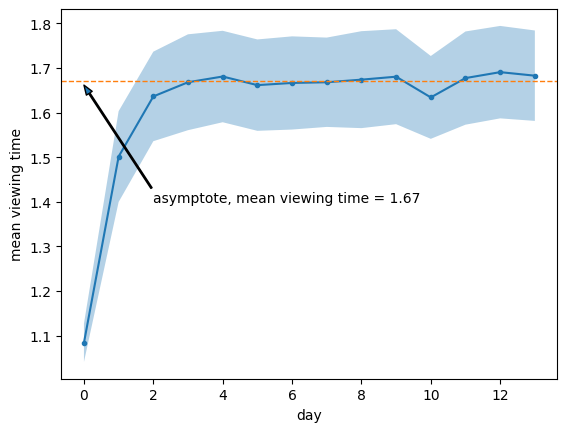

In [15]:
def horizontal_line(y_0):
    c = plt.axis()
    plt.autoscale(False)
    plt.plot([c[0], c[1]], [y_0, y_0], "--", linewidth=1)


arrow_props = {
    "width": 1,
    "headwidth": 5,
    "headlength": 7,
}

plt.plot(mean, ".-")
plt.fill_between(np.arange(len(mean)), mean - se, mean + se, alpha=0.333, linewidth=1)

asymp = mean[4:].mean()
horizontal_line(asymp)

plt.annotate(
    f"asymptote, mean viewing time = {asymp:.2f}",
    xy=[0, asymp - 0.01],
    xytext=[2, 1.4],
    arrowprops=arrow_props,
)

plt.xlabel("day")
plt.ylabel("mean viewing time");

In [16]:
np.random.seed(17)
recommender = RecommenderEpsilonGreedy(
    num_features=num_features, num_actions=num_actions, epsilon=0.1
)
mean_eps, se_eps = run_sequences(action_weights, num_actions, recommender)
betas_eg = recommender._betas

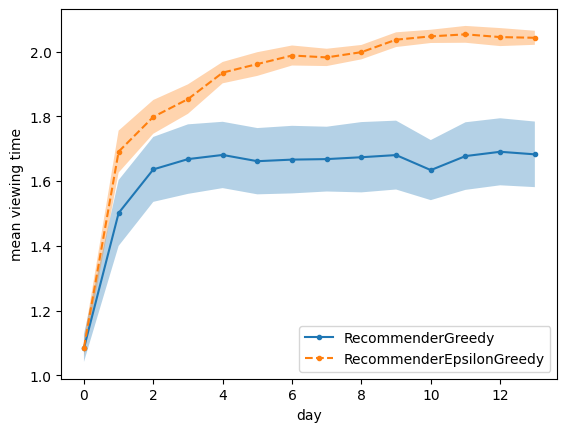

In [17]:
plt.plot(mean, ".-")
plt.plot(mean_eps, ".--")

plt.fill_between(np.arange(len(mean)), mean - se, mean + se, alpha=0.333, linewidth=1)

plt.fill_between(
    np.arange(len(mean_eps)),
    mean_eps - se_eps,
    mean_eps + se_eps,
    alpha=0.333,
    linewidth=1,
)

plt.legend(["RecommenderGreedy", "RecommenderEpsilonGreedy"])
plt.xlabel("day")
plt.ylabel("mean viewing time");

In [18]:
np.random.seed(17)
recommender = RecommenderThompsonSampling(
    num_features=num_features, num_actions=num_actions, num_bs_samples=30
)
mean_ts, se_ts = run_sequences(action_weights, num_actions, recommender)

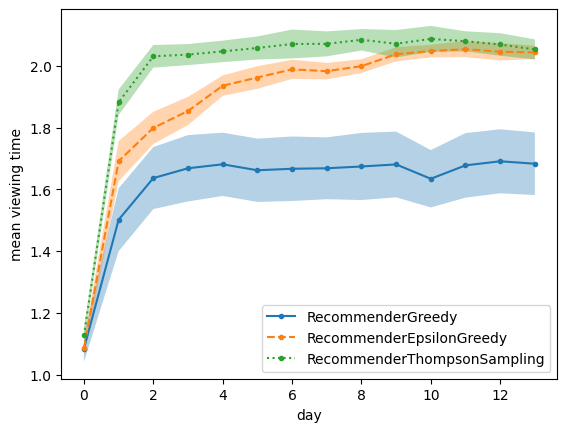

In [19]:
plt.plot(mean, ".-")
plt.plot(mean_eps, ".--")
plt.plot(mean_ts, ":.")

plt.fill_between(
    np.arange(len(mean)),
    mean - se,
    mean + se,
    alpha=0.333,
    linewidth=1,
)

plt.fill_between(
    np.arange(len(mean_eps)),
    mean_eps - se_eps,
    mean_eps + se_eps,
    alpha=0.333,
    linewidth=1,
)

plt.fill_between(
    np.arange(len(mean_eps)),
    mean_ts - se_ts,
    mean_ts + se_ts,
    alpha=0.333,
    linewidth=1,
)

plt.xlabel("day")
plt.ylabel("mean viewing time")
plt.legend(
    ["RecommenderGreedy", "RecommenderEpsilonGreedy", "RecommenderThompsonSampling"]
);